In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from scipy.optimize import brentq
from scipy.interpolate import interp1d


2025-05-03 12:59:28.677542: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 12:59:28.687151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746257368.698381   59066 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746257368.701811   59066 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746257368.710459   59066 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Load datasets
true_df = pd.read_csv("News-_dataset/True.csv")
fake_df = pd.read_csv("News-_dataset/Fake.csv")

# Add labels
true_df['label'] = 1
fake_df['label'] = 0

# Combine and shuffle
df = pd.concat([true_df, fake_df], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [3]:
# Drop nulls and duplicates
df.dropna(inplace=True)
df.drop_duplicates(subset=["title", "text"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39105 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    39105 non-null  object
 1   text     39105 non-null  object
 2   subject  39105 non-null  object
 3   date     39105 non-null  object
 4   label    39105 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [4]:
# Combine title and text
df['content'] = df['title'] + " " + df['text']
df.drop(columns=["title", "text", "date"], inplace=True)

df.head()

,subject,label,content
0,News,0,BREAKING: GOP Chairman Grassley Has Had Enoug...
1,News,0,Failed GOP Candidates Remembered In Hilarious...
2,News,0,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3,politicsNews,1,California AG pledges to defend birth control ...
4,politics,0,AZ RANCHERS Living On US-Mexico Border Destroy...


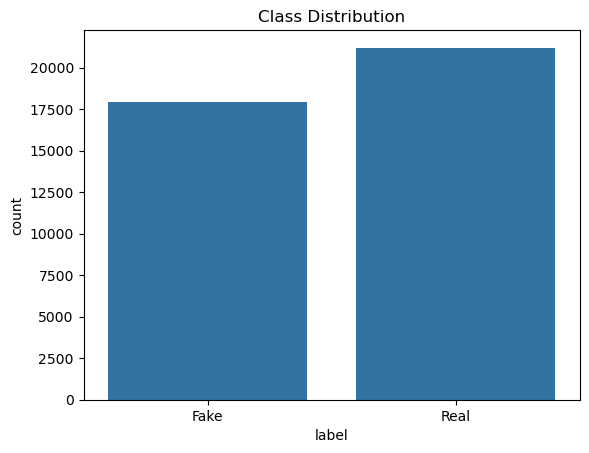

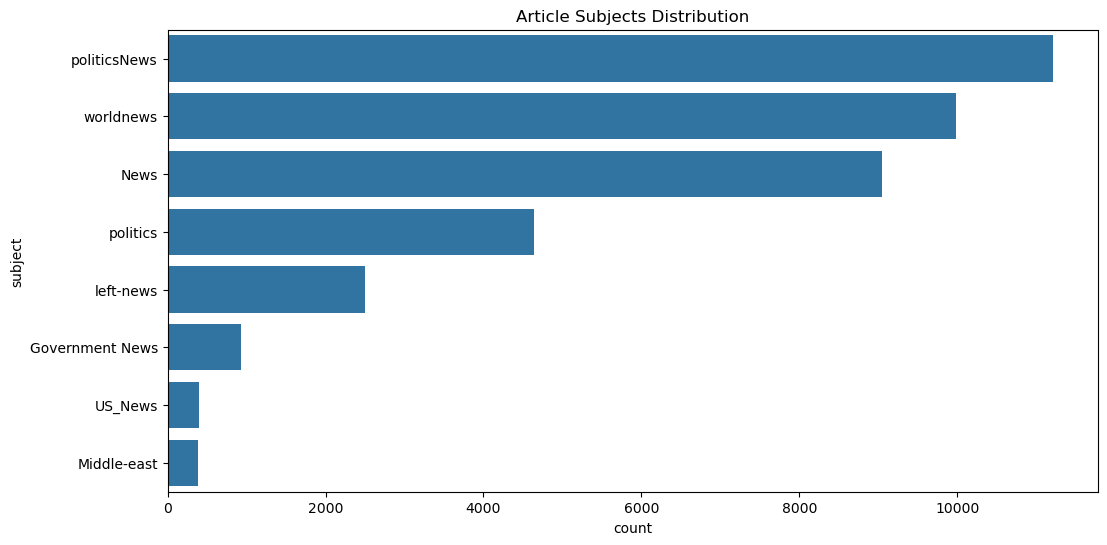

In [5]:
# Class distribution
sns.countplot(data=df, x='label')
plt.title("Class Distribution")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

# Subjects distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index)
plt.title("Article Subjects Distribution")
plt.show()


In [6]:
def clean_text(text):
    text = re.sub(r"reuters[^.]*\.", "", text)  # remove Reuters boilerplate
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_content'] = df['content'].apply(clean_text)

In [7]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['clean_content'])

sequences = tokenizer.texts_to_sequences(df['clean_content'])
X = pad_sequences(sequences, maxlen=300)
y = df['label'].values


In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 27373, Val: 7821, Test: 3911


In [9]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=300),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/home/ishank/.local/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746257382.209850   59066 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

Epoch 1/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 126s 286ms/step - accuracy: 0.8932 - loss: 0.2694 - val_accuracy: 0.9762 - val_loss: 0.0709
Epoch 2/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 119s 277ms/step - accuracy: 0.9772 - loss: 0.0745 - val_accuracy: 0.9797 - val_loss: 0.0698
Epoch 3/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 120s 280ms/step - accuracy: 0.9866 - loss: 0.0385 - val_accuracy: 0.9772 - val_loss: 0.0713
Epoch 4/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 124s 290ms/step - accuracy: 0.9905 - loss: 0.0333 - val_accuracy: 0.9776 - val_loss: 0.0711


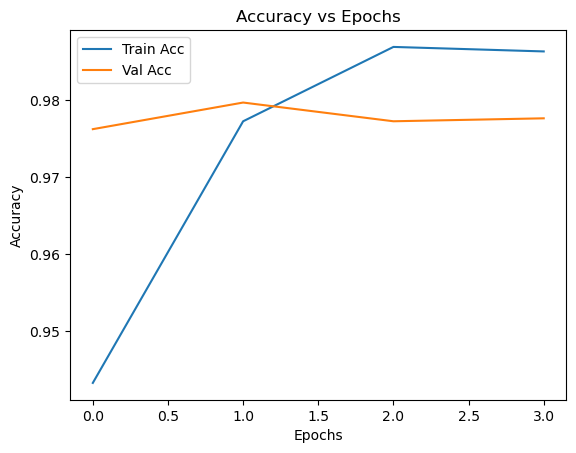

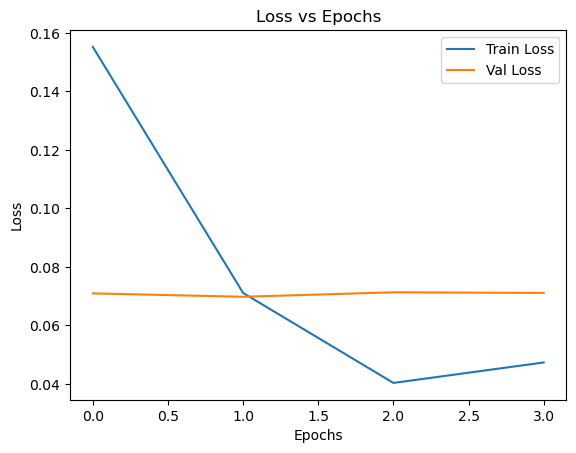

In [11]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import roc_curve

y_pred_prob = model.predict(X_test).flatten()
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Accuracy, AUC, Precision
acc = np.mean(y_pred_class == y_test)
auc_score = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred_class)

# Equal Error Rate (EER)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"EER: {eer:.4f}")


123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step
Accuracy: 0.9785
AUC: 0.9940
Precision: 0.9696
EER: 0.0236


Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.96      0.98      1791
        Real       0.97      0.99      0.98      2120

    accuracy                           0.98      3911
   macro avg       0.98      0.98      0.98      3911
weighted avg       0.98      0.98      0.98      3911



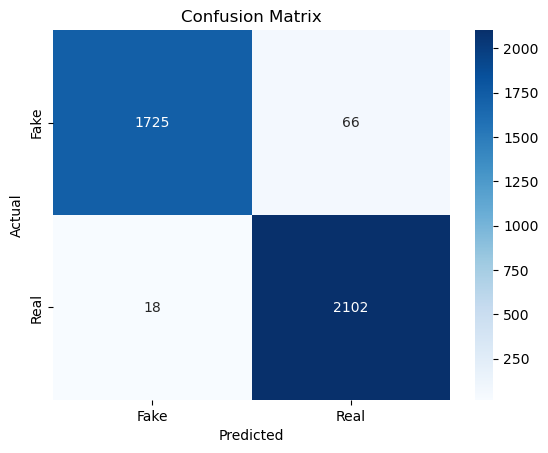

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred_class, target_names=["Fake", "Real"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


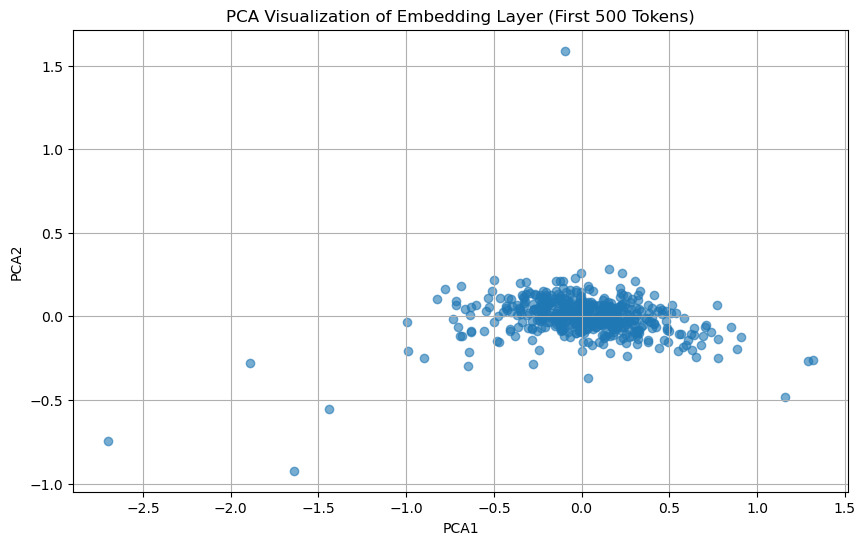

In [14]:
embedding_weights = model.layers[0].get_weights()[0]
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_weights[:500])

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6)
plt.title("PCA Visualization of Embedding Layer (First 500 Tokens)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(True)
plt.show()
